In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
from pneumo import dataset
from torch.utils.data import DataLoader
import os
import glob
import albumentations as A

In [3]:
IMG_PATH = "/home/wilmer-linux/Projects/data/pneumo_s1/dicom-images-train/"
LABEL_PATH = os.path.join(IMG_PATH, '../train-rle.csv')

fns = glob.glob(os.path.join(IMG_PATH, "**/*.dcm"), recursive=True)

In [4]:
from sklearn.model_selection import train_test_split

train_fns, valid_fns = train_test_split(fns, train_size=0.8, random_state=42, shuffle=True)
print(len(train_fns), len(valid_fns))

9671 2418


In [5]:
config = {
    "lr" : 1e-3,
    "batch_size": 4,
}

In [6]:
from albumentations import (
    Compose, HorizontalFlip,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop, Resize, RandomBrightnessContrast, ToFloat
)

IMG_SIZE= (256, 256)

VALID_AUGS = Compose([
    ToFloat(max_value=1),
    Resize(IMG_SIZE[0], IMG_SIZE[1])
])

In [7]:
valid_ds = dataset.PneumoDataset(LABEL_PATH, valid_fns, transforms=VALID_AUGS)
valid_loader = DataLoader(valid_ds, batch_size=config["batch_size"], shuffle=False, num_workers=4, multiprocessing_context='spawn')

In [20]:
from pneumo.models import UNetLightning

model_name = "unet++_effb2_dropout0_mixedlogdiceloss"
ckpt_path = "/home/wilmer-linux/Projects/code/pneumo/ckpt/"

model = UNetLightning.load_from_checkpoint(os.path.join(ckpt_path, f"{model_name}.ckpt")).cuda()

In [25]:
from pneumo.metrics import dice_coeff
from tqdm.notebook import tqdm

xs=np.linspace(0, 1., num=21)
dice_coeffs=[]

for x in xs:
    count = 0
    total = 0
    for batch in tqdm(valid_loader):
        count+=1
        total +=dice_coeff(model(batch['img'].float()), batch["target"].float(), x)
    print(f"threshold: {x}, dice: {total/count}")
    dice_coeffs.append(total/count)

  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.0, dice: 0.38073769211769104


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.05, dice: 0.3862054646015167


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.1, dice: 0.5286738276481628


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.15000000000000002, dice: 0.5609719753265381


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.2, dice: 0.5738736987113953


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.25, dice: 0.5749944448471069


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.30000000000000004, dice: 0.5691628456115723


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.35000000000000003, dice: 0.5608494281768799


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.4, dice: 0.5500531792640686


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.45, dice: 0.5362954139709473


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.5, dice: 0.5233950614929199


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.55, dice: 0.5078408122062683


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.6000000000000001, dice: 0.3799062669277191


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.65, dice: 0.37633073329925537


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.7000000000000001, dice: 0.37543031573295593


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.75, dice: 0.3752176761627197


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.8, dice: 0.3752066195011139


  0%|          | 0/605 [00:00<?, ?it/s]

threshold: 0.8500000000000001, dice: 0.3752066195011139


  0%|          | 0/605 [00:00<?, ?it/s]

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


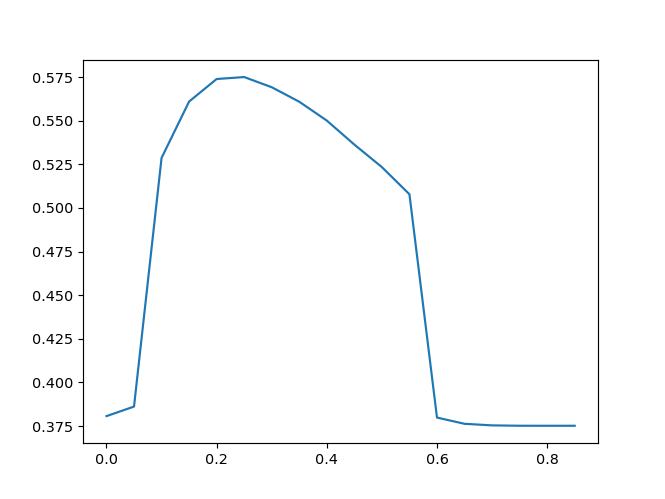

In [31]:
%matplotlib notebook

from matplotlib import pyplot as plt

coeffs= [c.cpu().numpy() for c in dice_coeffs]
plt.plot(xs[:len(coeffs)], coeffs)

In [15]:
THRESHOLD = 0.35

In [3]:
import glob
import os

TEST_PATH = "/home/wilmer-linux/Projects/data/pneumo_s2/"
test_fns = glob.glob(os.path.join(TEST_PATH, "**/*.dcm"), recursive=True)

In [22]:
import glob
import os
from typing import Optional

import albumentations as alb
import numpy as np
import pandas as pd
import pydicom
from pydicom.dataset import FileDataset
from torch.utils.data import Dataset

from pneumo.mask_functions import mask2rle, rle2mask
import torch
from typing import Dict, Any

class TestDataset(Dataset):
    def __init__(
        self,
        dcm_paths,
        transforms: Optional[alb.core.composition.Compose] = None,
    ):
        self.fns = dcm_paths
        self.transforms = transforms

    def load_dcm(self, dcm: FileDataset):
        return {
            "img": dcm.pixel_array / 255,
            "age": dcm.PatientAge,
            "sex": dcm.PatientSex,
            "view_position": dcm.ViewPosition,
        }

    def __getitem__(self, idx: int):
        """Return a dict to be used by the data loader"""
        fn = self.fns[idx]
        dcm = pydicom.dcmread(fn)
        dcm_data = self.load_dcm(dcm)
        dcm_data["id"] = os.path.basename(os.path.splitext(fn)[0])

        if self.transforms:
            transformed = self.transforms(
                image=dcm_data["img"]
            )
            dcm_data["img"] = transformed["image"]
        dcm_data["img"] = np.expand_dims(dcm_data["img"], axis=0).astype(np.float32)
        return self.to_tensors(dcm_data)

    def to_tensors(self, data: Dict[str, Any]):
        view = 1. if data["view_position"] == "PA" else 0.
        age = float(data["age"])
        sex = 1. if data["sex"] == "F" else 0.
        
        return {
            "id": data["id"],
            "age": torch.as_tensor(age),
            "sex": torch.as_tensor(sex),
            "pos": torch.as_tensor(view),
            "img": torch.as_tensor(data["img"]),
        }

    def __len__(self):
        return len(self.fns)

In [23]:
test_ds = TestDataset(test_fns, transforms=VALID_AUGS)
test_loader = DataLoader(test_ds, batch_size=8, num_workers=0)

In [25]:
model= model.cpu()

In [27]:
from tqdm.notebook import tqdm

res_dict={}

for batch in tqdm(test_loader):
    model.eval()
    preds = model(batch['img'])
    
    for uid, pred in zip(batch['id'], preds):
        mask = (pred>THRESHOLD).float()[0]
        rle = mask2rle(mask, 256, 256)
        if rle == "":
            res_dict[uid] = -1
        else:
            res_dict[uid] = rle

  0%|          | 0/401 [00:00<?, ?it/s]

In [30]:
with open(f"{model_name}.csv", "w") as f:
    f.write(f"ImageId,EncodedPixels\n")    
    for uid, rle in res_dict.items():
        f.write(f"{uid},{rle}\n")